# Construction Cash Flow Optimization

### Importing Packages

In [67]:
import logging
import pickle
import copy
import numpy as np
import matplotlib.pyplot as plt

### Configuration

In [56]:
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s]%(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams["figure.dpi"] = 120

### Initiate a project

In [57]:
class Project: pass  # Create a blank class
project = Project()  # Initiate a blank project object
project.start = np.datetime64("2019-01-01")
project.number_of_activities = 50
project.dur = np.zeros(project.number_of_activities)  # duration

### Randomize the project

In [58]:
# Randomize the durations, costs, and preds
project.dur = np.array([np.timedelta64(np.random.randint(5, 30), 'D') for i in range(project.number_of_activities)])
project.cost = np.random.randint(5, 20, size=(project.number_of_activities))
project.pred = [
    [i - np.random.randint(1, i), ] if i > 1 else [] 
    for i in range(project.number_of_activities)
]

### Financial Parameters for the project

In [127]:
project.downpayment = 0.15
project.retention = 0.1
project.payment_days = 28
project.markup = 0.05
project.interest = 0.10

## Calculate the project

In [60]:
# Initiate ES and EF
project.es = np.array([project.start for i in range(project.number_of_activities)])
project.ef = project.es + project.dur
# Perform Front Run
logging.info("Starting the Front Run...")
cond = True
while cond:
    cond = False
    for i in range(project.number_of_activities):
        for pred in project.pred[i]:
            if project.es[i] < project.ef[pred]:
                project.es[i] = project.ef[pred]
                project.ef[i] = project.es[i] + project.dur[i]
                cond = True
del cond
# Record the project finish
project.finish = project.ef.max()
# Perform the Back Run
logging.info("Starting the Back Run...")
# Intiate the LS and LF
project.lf = np.array([project.finish for i in range(project.number_of_activities)])
project.ls = project.lf - project.dur
cond = True
while cond:
    cond = False
    for i in range(project.number_of_activities):
        for pred in project.pred[i]:
            if project.lf[pred] > project.ls[i]:
                project.lf[pred] = project.ls[i]
                project.ls[pred] = project.lf[pred] - project.dur[pred]
                cond = True
del cond
# Calculate the TF
project.tf = project.ls - project.es
logging.info("Done!")

[09:55:35]INFO: Starting the Front Run...
[09:55:35]INFO: Starting the Back Run...
[09:55:35]INFO: Done!


## Plot the Calculated Schedule

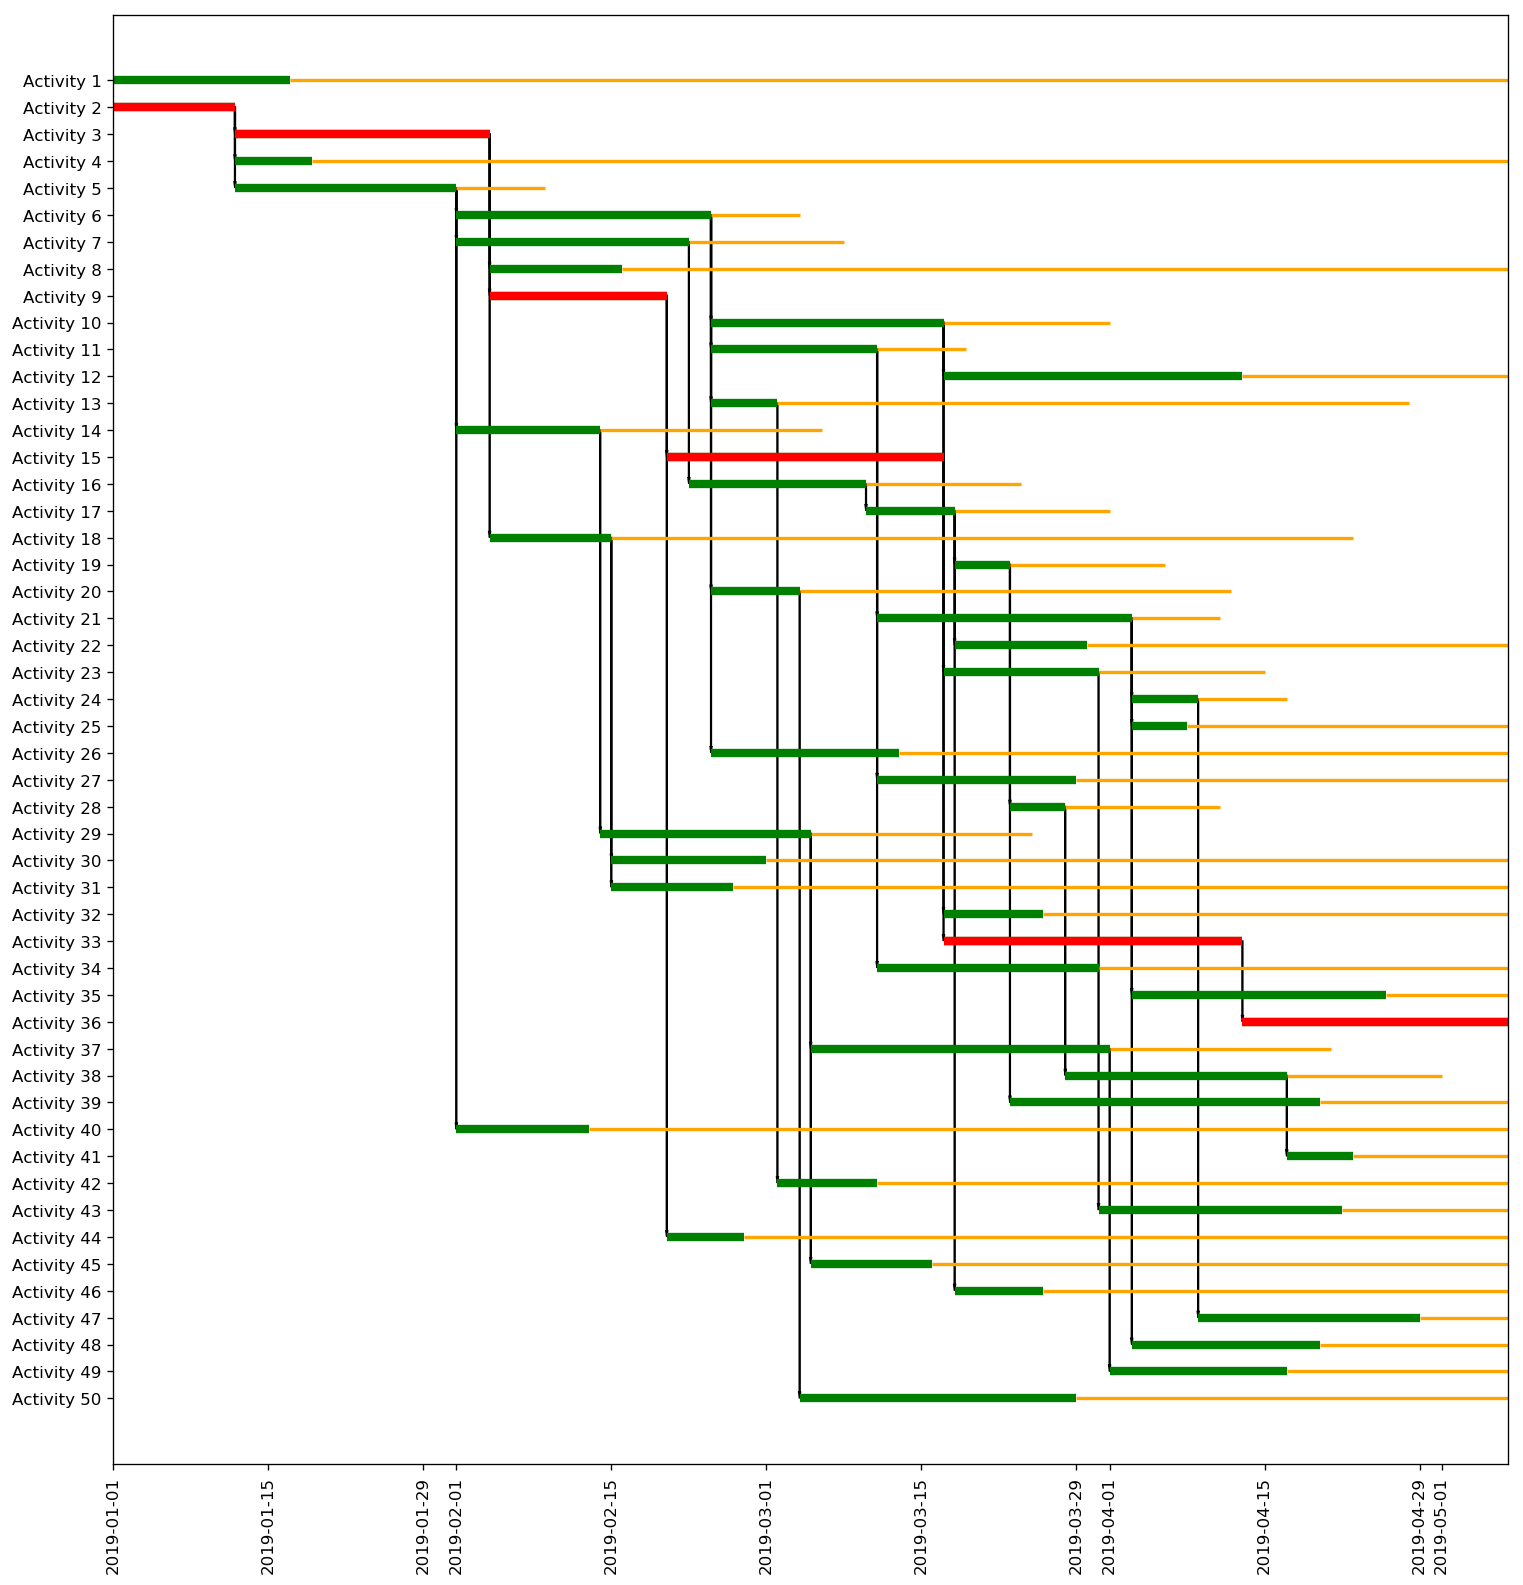

In [61]:
plt.figure(figsize=(15, int(project.number_of_activities / 3)))
# Draw Activities
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=project.es,
    xmax=project.ef,
    linewidth=5,
    color="green"
)
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=np.array([project.es[i] if project.es[i] == project.ls[i] else project.es[i] for i in range(project.number_of_activities)]),
    xmax=np.array([project.ef[i] if project.es[i] == project.ls[i] else project.es[i] for i in range(project.number_of_activities)]),
    linewidth=5,
    color="red"
)
# Draw Late
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=project.ef,
    xmax=project.lf,
    linewidth=2,
    color="orange"
)
# Draw Arrow
for i in range(project.number_of_activities):
    for pred in project.pred[i]:
        plt.arrow(
            x=project.ef[pred],
            y=pred,
            dx=(project.ef[pred]-project.es[i]).astype('timedelta64[D]')/np.timedelta64(1,"D"),
            dy=i-pred,
            length_includes_head=True,
            width=0.05,
            color="black"
        )
plt.xlim(project.start, project.finish)
plt.xticks(rotation=90)
plt.gca().invert_yaxis()
plt.show()

## Calculate the Cash-Flow

In [88]:
# Initiate an array with the dates
project.time = np.arange(project.start, project.finish + np.timedelta64(project.payment_days, "D"))
# Calculate the number of days
project.number_of_days = int((project.finish - project.start + np.timedelta64(project.payment_days, "D")) / np.timedelta64(1, "D"))
# Initiate the array for the cashflow
project.cashout = np.zeros(project.number_of_days)
# Calculate the cashout
for t in range(project.number_of_days):
    for i in range(project.number_of_activities):
        if project.time[t] > project.es[i] and project.time[t] <= project.ef[i]:
            project.cashout[t] += project.cost[i] / int(project.dur[i] / np.timedelta64(1, "D"))
# Calculate the cashin
project.cashin = np.zeros(project.number_of_days)

for t in range(project.number_of_days):
    if t > project.payment_days and str(project.time[t]).split("-")[2] == "01":
        project.cashin[t] += (
            project.cashout[0:t].sum()
            - project.cashin[0:t].sum()
        )
project.cashin *= (1 + project.markup) * (1 - project.downpayment)
project.cashin[0] = project.cost.sum() * (1 + project.markup) * project.downpayment
project.cashin[project.number_of_days-1] = project.cost.sum() * (1 + project.markup) - project.cashin.sum()
# Calculate the overdraft
project.overdraft = project.cashin.cumsum() - project.cashout.cumsum()

### CashIn and CashOut Cummulative

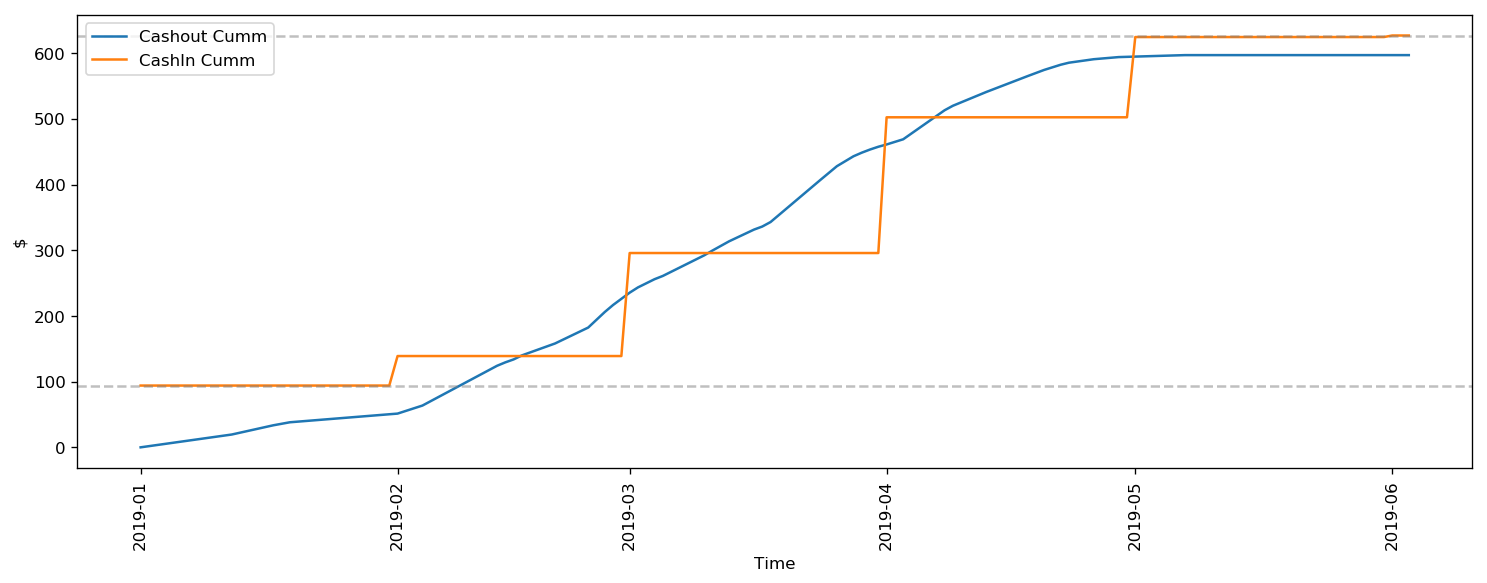

In [63]:
plt.figure()
plt.plot(project.time, project.cashout.cumsum(), label="Cashout Cumm")
plt.plot(project.time, project.cashin.cumsum(), label="CashIn Cumm")
plt.axhline(project.cost.sum() * (1 + project.markup), linestyle="--", color="grey", alpha=0.5)
plt.axhline(project.cost.sum() * (1 + project.markup) * project.downpayment, linestyle="--", color="grey", alpha=0.5)
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("$")
plt.legend(loc=2)
plt.show()

### Overdraft

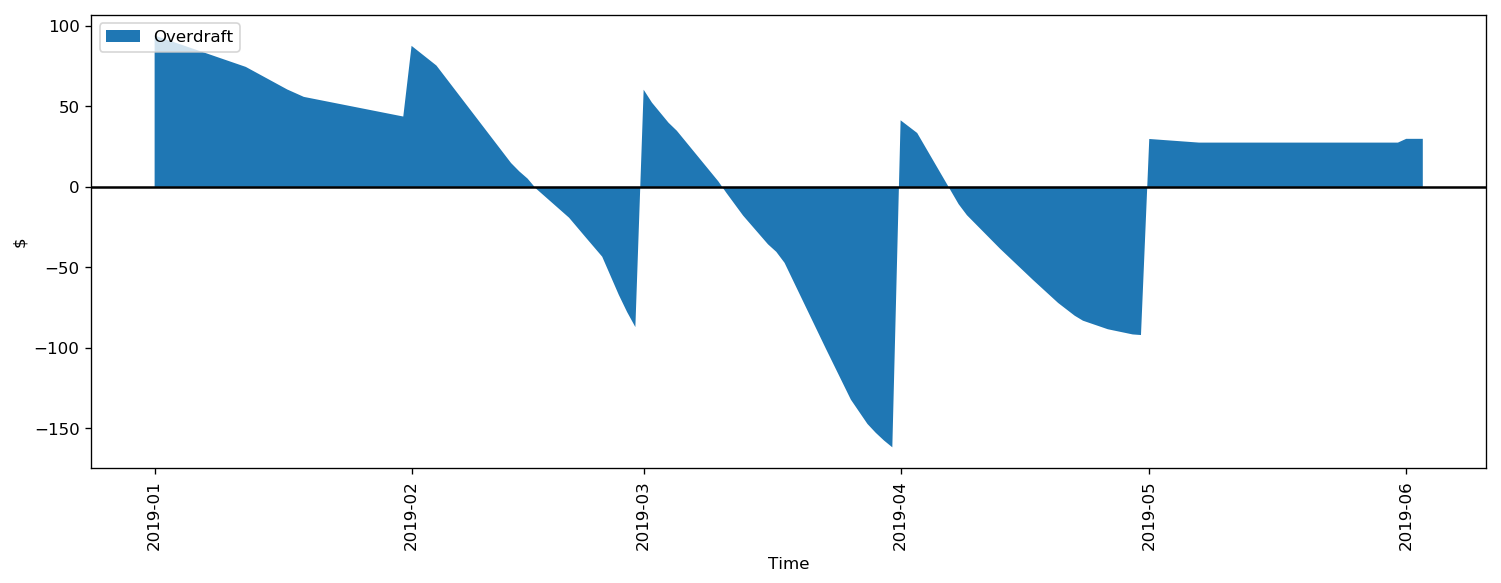

In [64]:
plt.figure()
plt.fill_between(project.time, (project.cashin.cumsum() - project.cashout.cumsum()), label="Overdraft")
plt.axhline(0, color="Black")
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("$")
plt.legend(loc=2)
plt.show()

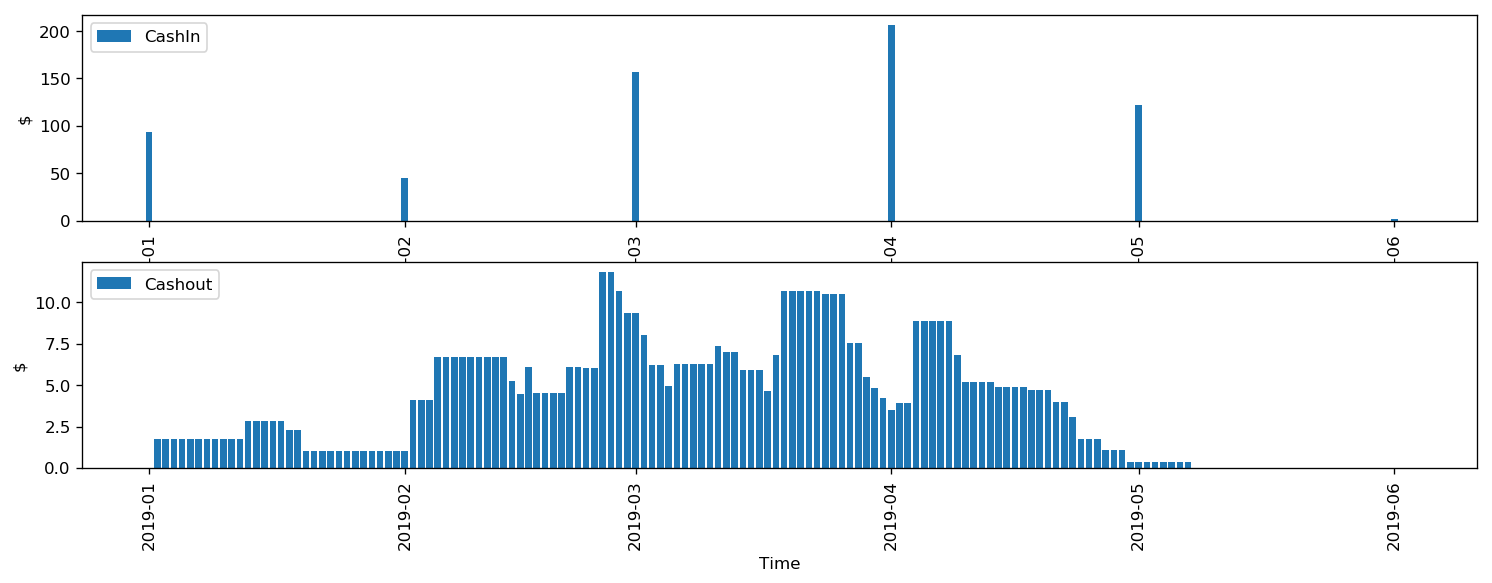

In [65]:
ax = plt.subplot(211)
plt.bar(project.time, project.cashin, label="CashIn")
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("$")
plt.legend(loc=2)
plt.xticks(ticks=[])
plt.subplot(212, sharex=ax)
plt.bar(project.time, project.cashout, label="Cashout")
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("$")
plt.legend(loc=2)
plt.show()

### Optimization

In [107]:
print(hash(pickle.dumps(project)))
p = copy.deepcopy(project)
print(hash(pickle.dumps(p)))

-1857326605
-1857326605


[15:38:59]INFO: Done 0% @ Iteration 0
[15:39:26]INFO: Done 5% @ Iteration 500
[15:39:54]INFO: Done 10% @ Iteration 1000
[15:40:17]INFO: Found better solution at iteration 1438
[15:40:20]INFO: Done 15% @ Iteration 1500
[15:40:46]INFO: Done 20% @ Iteration 2000
[15:41:13]INFO: Done 25% @ Iteration 2500
[15:41:39]INFO: Done 30% @ Iteration 3000
[15:42:06]INFO: Done 35% @ Iteration 3500
[15:42:32]INFO: Done 40% @ Iteration 4000
[15:42:58]INFO: Done 45% @ Iteration 4500
[15:42:58]INFO: Found better solution at iteration 4503
[15:43:24]INFO: Done 50% @ Iteration 5000
[15:44:15]INFO: Done 60% @ Iteration 6000
[15:44:40]INFO: Done 65% @ Iteration 6500
[15:45:04]INFO: Done 70% @ Iteration 7000
[15:45:30]INFO: Done 75% @ Iteration 7500
[15:45:58]INFO: Done 80% @ Iteration 8000
[15:46:26]INFO: Done 85% @ Iteration 8500
[15:46:53]INFO: Done 90% @ Iteration 9000
[15:47:19]INFO: Done 95% @ Iteration 9500
[15:47:45]INFO: Done!


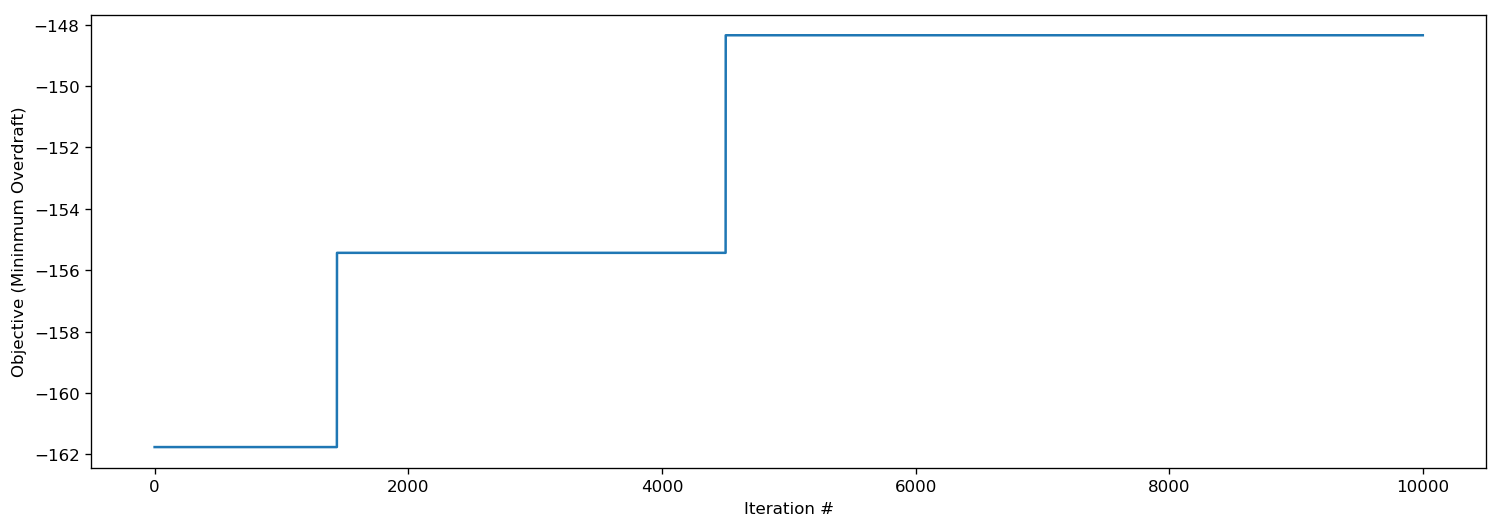

In [111]:
# The objective here is to reduce the negative overdraft
max_iterations = 10000
# initiate the lags
project.lags = np.timedelta64(0,"D")
project.os = project.es
project.of = project.ef
project.opt_cashin = project.cashin
project.opt_cashout = project.cashout
project.opt_overdraft = project.overdraft
best_overdraft = np.zeros(max_iterations) # Keep track of the best
tested_lags = [] # keep track of the tested lags
for iteration in range(max_iterations):
    p = copy.deepcopy(project)
    # Randomize the lags
    p.lags = [
        np.timedelta64(np.random.randint(0, int(p.tf[i]/np.timedelta64(1, 'D'))), "D") 
        if int(p.tf[i]/np.timedelta64(1, 'D')) > 0 else np.timedelta64(0, "D")
        for i in range(p.number_of_activities)
    ]
    lag_hash = hash(pickle.dumps(p.lags))
    if lag_hash in tested_lags:
        log.info("Same lag tested! skipping iteration {}".format(iteration))
        best_overdraft[iteration] = p.overdraft.min()
        continue
    else:
        tested_lags.append(lag_hash)
    # Initiate the the os and of
    p.os = p.es + p.lags
    p.of = p.os + p.dur
    # caculate the new schedule
    cond = True
    while cond:
        cond = False
        for i in range(project.number_of_activities):
            for pred in project.pred[i]:
                if p.os[i] < p.of[pred]:
                    p.os[i] = p.of[pred]
                    p.of[i] = p.os[i] + p.dur[i]
                    cond = True
    del cond
    # Calculate the new Cash flow
    project.opt_cashout = np.zeros(project.number_of_days)
    # Calculate the cashout
    for t in range(p.number_of_days):
        for i in range(p.number_of_activities):
            if p.time[t] > p.os[i] and p.time[t] <= p.of[i]:
                p.opt_cashout[t] += p.cost[i] / int(p.dur[i] / np.timedelta64(1, "D"))
    # Calculate the cashin
    p.opt_cashin = np.zeros(p.number_of_days)
    for t in range(p.number_of_days):
        if t > p.payment_days and str(p.time[t]).split("-")[2] == "01":
            p.opt_cashin[t] += (
                p.opt_cashout[0:t].sum()
                - p.opt_cashin[0:t].sum()
            )
    p.opt_cashin *= (1 + p.markup) * (1 - p.downpayment)
    p.opt_cashin[0] = p.cost.sum() * (1 + p.markup) * p.downpayment
    p.opt_cashin[p.number_of_days-1] = p.cost.sum() * (1 + p.markup) - p.cashin.sum()
    p.opt_overdraft = p.opt_cashin.cumsum() - p.opt_cashout.cumsum()
    # logging.info("{} -> {}".format(project.opt_overdraft.min(), p.opt_overdraft.min()))
    if p.opt_overdraft.min() > project.opt_overdraft.min():
        project = copy.deepcopy(p)
        logging.info("Found better solution at iteration {}".format(iteration))
    if (iteration/max_iterations*100) % 5 == 0:
        logging.info("Done {}% @ Iteration {}".format(int(iteration/max_iterations*100), iteration))
    best_overdraft[iteration] = project.opt_overdraft.min()
logging.info("Done!")
plt.figure()
plt.plot(np.arange(max_iterations), best_overdraft)
plt.xlabel("Iteration #")
plt.ylabel("Objective (Mininmum Overdraft)")
plt.show()

### Draw Optimized Schedule

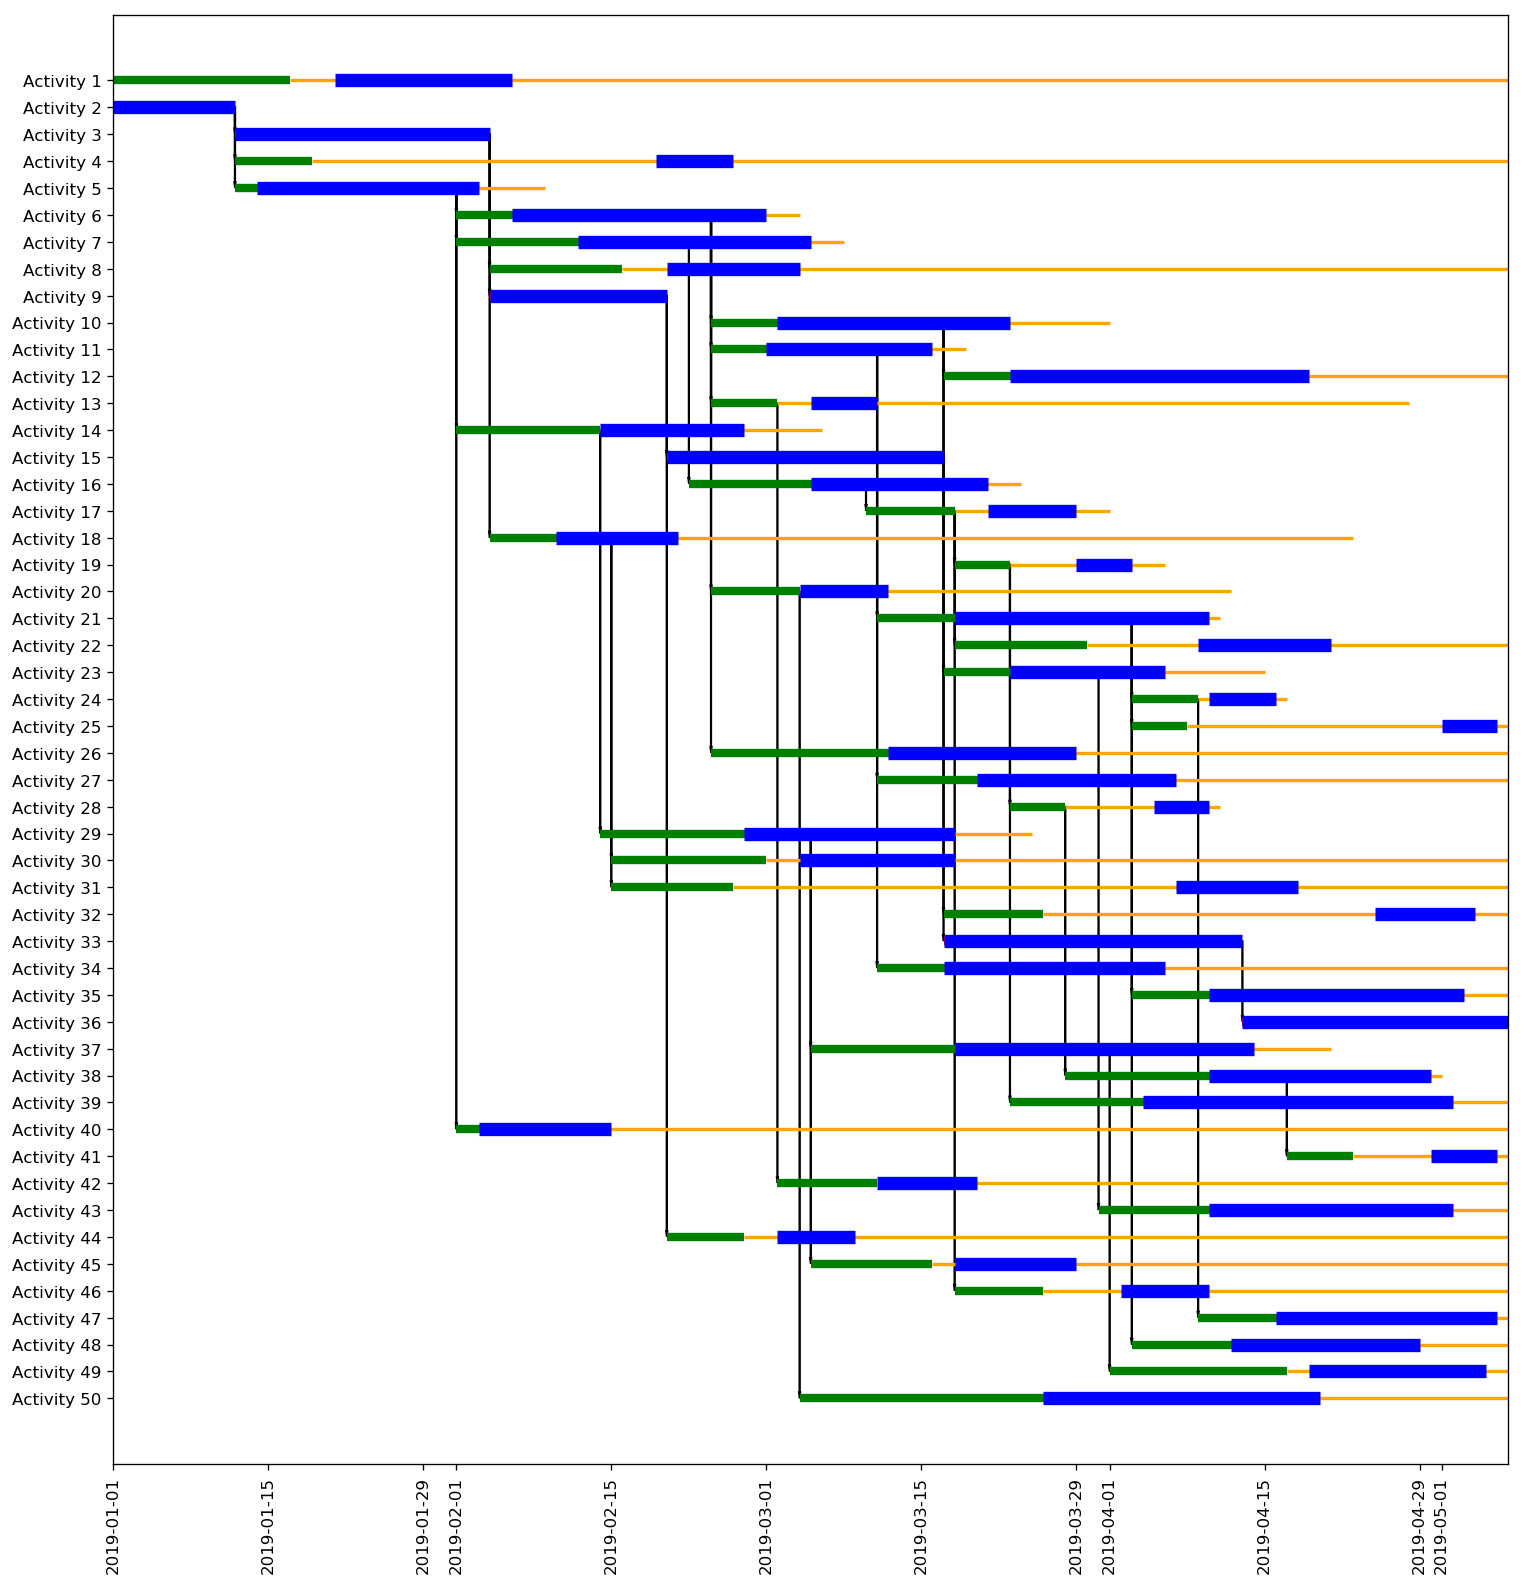

In [120]:
plt.figure(figsize=(15, int(project.number_of_activities / 3)))
# Draw Activities
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=project.es,
    xmax=project.ef,
    linewidth=5,
    color="green"
)
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=np.array([project.es[i] if project.es[i] == project.ls[i] else project.es[i] for i in range(project.number_of_activities)]),
    xmax=np.array([project.ef[i] if project.es[i] == project.ls[i] else project.es[i] for i in range(project.number_of_activities)]),
    linewidth=5,
    color="red"
)
# Draw Late
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=project.ef,
    xmax=project.lf,
    linewidth=2,
    color="orange"
)
plt.hlines(
    y = ["Activity {}".format(i+1) for i in range(project.number_of_activities)],
    xmin=project.os,
    xmax=project.of,
    linewidth=8,
    color="blue"
)
# Draw Arrow
for i in range(project.number_of_activities):
    for pred in project.pred[i]:
        plt.arrow(
            x=project.ef[pred],
            y=pred,
            dx=(project.ef[pred]-project.es[i]).astype('timedelta64[D]')/np.timedelta64(1,"D"),
            dy=i-pred,
            length_includes_head=True,
            width=0.05,
            color="black"
        )
plt.xlim(project.start, project.finish)
plt.xticks(rotation=90)
plt.gca().invert_yaxis()
plt.show()

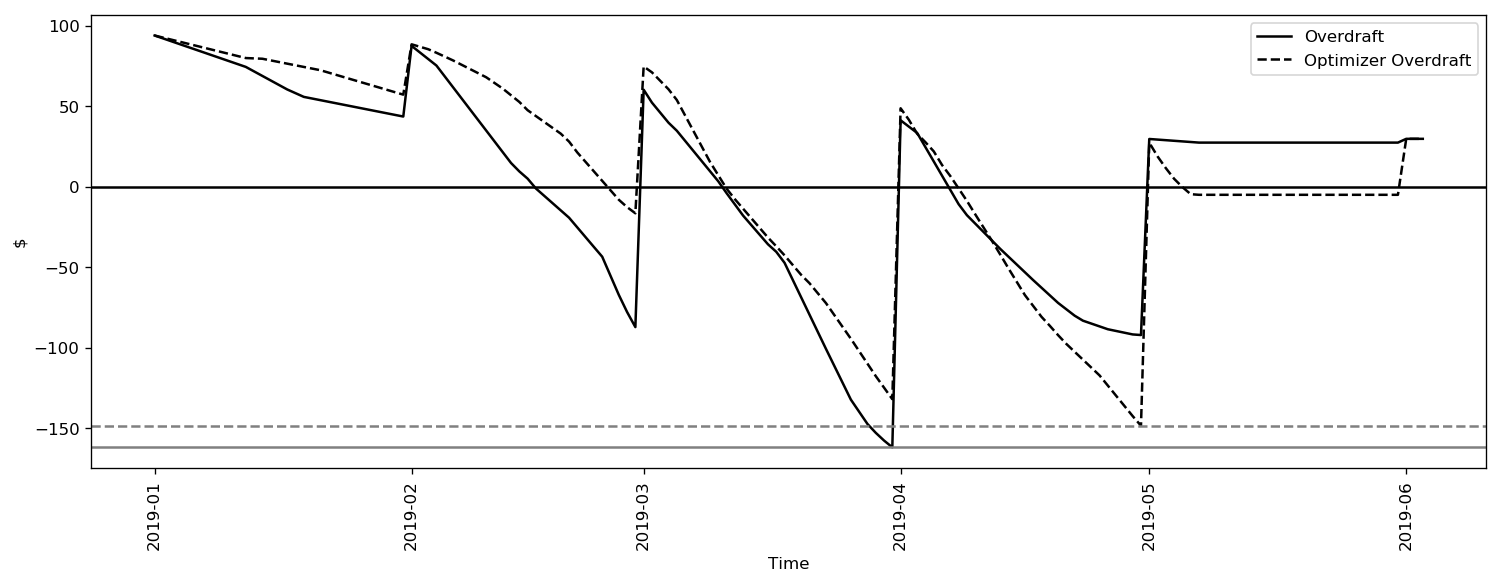

In [117]:
plt.figure()
plt.plot(project.time, project.overdraft, label="Overdraft", linestyle="-", color="k")
plt.plot(project.time, project.opt_overdraft, label="Optimizer Overdraft", linestyle="--", color="k")
plt.axhline(0, color="Black")
plt.axhline(project.overdraft.min(), color="grey", linestyle="-")
plt.axhline(project.opt_overdraft.min(), color="grey", linestyle="--")
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("$")
plt.legend(loc=1)
plt.show()

In [138]:
np.exp(project.interest * 0 / 365*20)

1.0

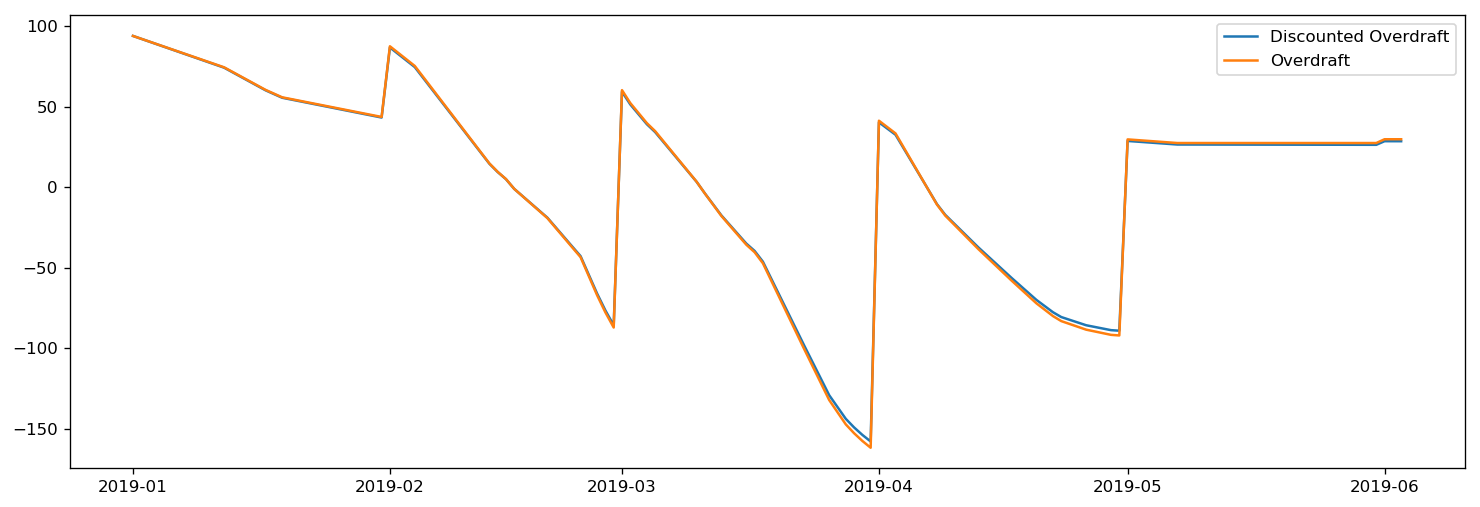

In [142]:
plt.plot(
    project.time,
    np.array(
        [
            project.overdraft[i] / np.exp(project.interest * i / 365)
            for i in range(project.number_of_days)
        ]
    ),
    label="Discounted Overdraft"
)
plt.plot(
    project.time, 
    project.overdraft,
    label="Overdraft"
)
plt.legend()
plt.show()